In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import utils

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [4]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [5]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Visual analysis

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux_err
    obj['passband'] = passband
    return obj

In [12]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [13]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)
    
def plot_loghist(x, bins, **kwargs):
    """
    https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
    """
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, **kwargs)
    plt.xscale('log')
    
def plot_metrics_histogram(report, **hist_kwargs):
    plt.figure(figsize=(20, 20))
    for idx, metric in enumerate(report.columns[1:], 1):
        plt.subplot(3, 2, idx)
        plot_loghist(report[metric], bins=50)
        plt.xlabel(metric, size=14)
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.xscale('log')
        plt.grid()
    plt.show()

34299


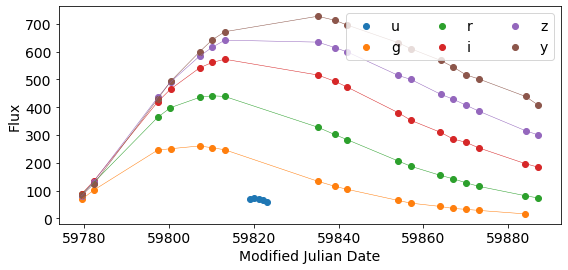

43812


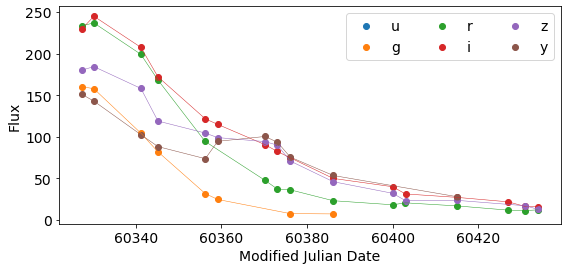

70046


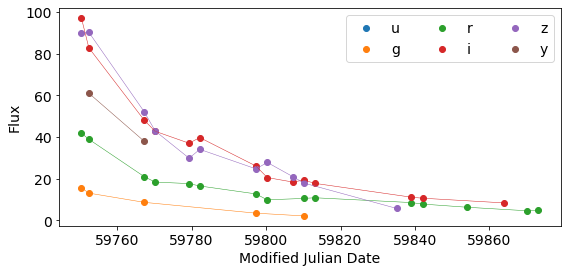

84716


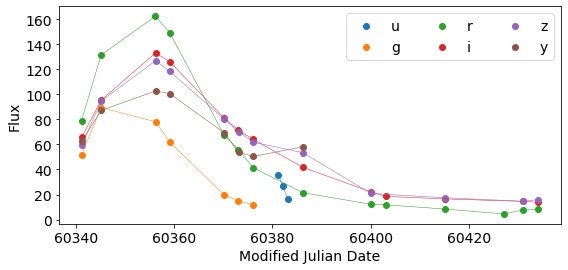

131629


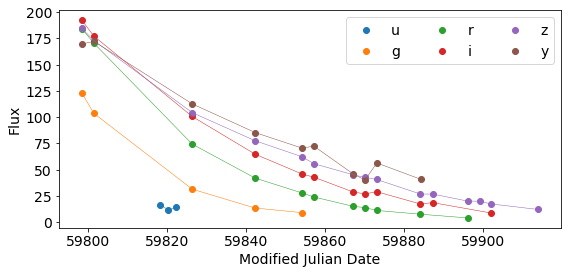

169315


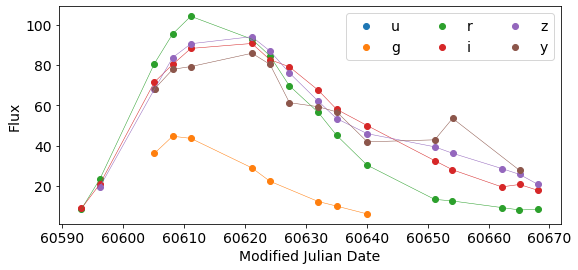

229855


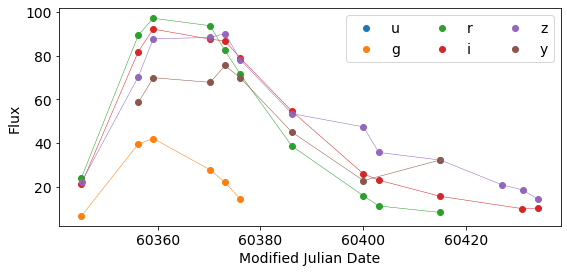

251430


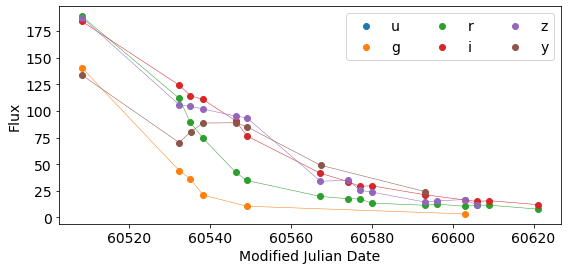

282714


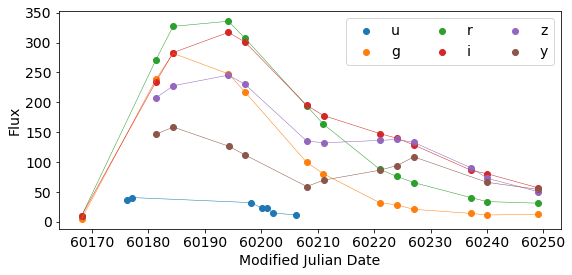

290682


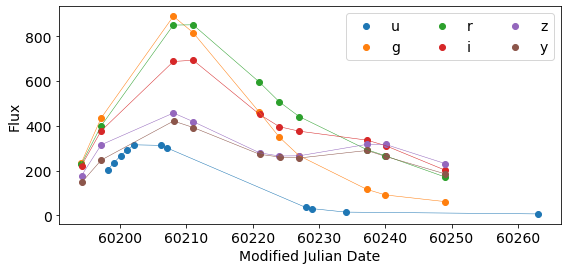

316306


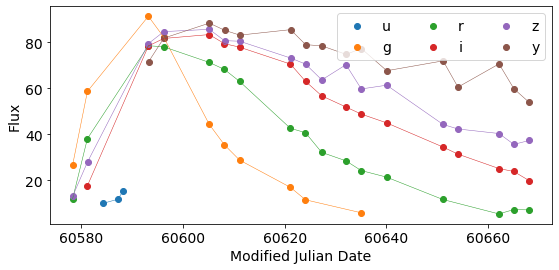

In [14]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()

# One object test Test

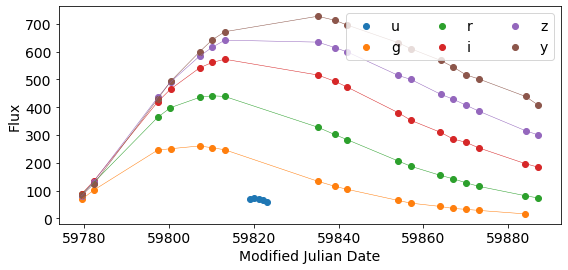

In [15]:
anobject = get_object(data, 34299)

plot_light_curves(anobject)

In [16]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

In [17]:
import rbfnet_aug

# fit augmentation model
model = rbfnet_aug.RBFNetAugmentation(passband2lam, n_hidden=300, lam=0., n_epochs=300, lr=0.01, batch_size=100)
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                 anobject['mjd'].max(), n_obs=1000)

In [18]:
anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, 
                                 flux_err_pred, anobject_test['passband'].values)
anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)

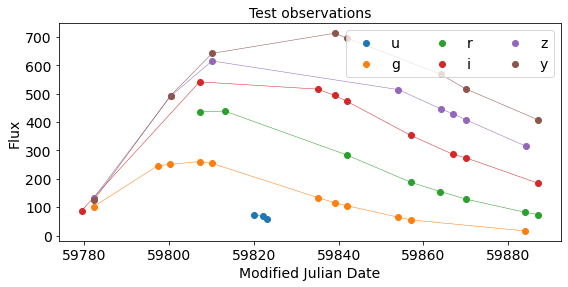

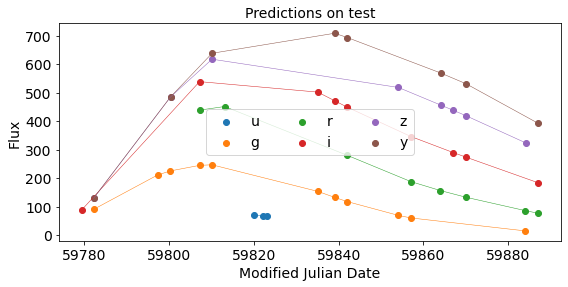

In [19]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

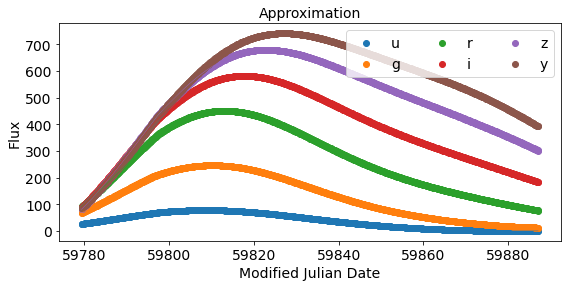

In [20]:
plot_light_curves(anobject_aug, "Approximation")

In [21]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  11.160983658420355
MAE:  8.138197716021597
RSE:  0.05633451848314327
RAE:  0.046473748923665945
MAPE:  4.104278363600688


# Test on many objects

In [22]:
report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in object_ids:
    
    # get an object
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    
    print("Object ", i, " with ", len(anobject), " observations")
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)    
    
    # fit augmentation model
    model = rbfnet_aug.RBFNetAugmentation(passband2lam, n_hidden=300, lam=0., n_epochs=300, lr=0.01, batch_size=100)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)
    
    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)
    anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, 
                                     flux_err_pred, anobject_test['passband'].values)
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                      anobject_test_pred['flux'].values)
    print(metrics)
    report.loc[len(report), :] = [i] + list(metrics)

Object  745  with  61  observations
[5.822825751938372, 3.6876001696629683, 0.11123582136545812, 0.09972665980493015, 10.540574788368472]
Object  1124  with  61  observations
[5.546642764695038, 3.441307618805916, 0.14917287475401048, 0.1285686058002127, 13.37952291756637]
Object  1920  with  55  observations
[14.277356823028356, 8.506273363161359, 0.23082266368847626, 0.17016464638814136, 26.758247597011994]
Object  2922  with  58  observations
[15.12523483194125, 6.952594992688407, 0.21858394385919003, 0.19752467936110865, 13.431861960099729]
Object  4173  with  77  observations
[3.172288583773302, 2.2698521021681555, 0.06397888536568415, 0.05531228686377143, 6.047525832120748]
Object  4389  with  58  observations
[3.1731482302981693, 2.421967665311617, 0.11714995933027147, 0.11160673019939213, 11.572532326389839]
Object  4819  with  73  observations
[28.11859731341058, 12.617036676220865, 0.4709991609214996, 0.3110409011554645, 28.405530917651518]
Object  6180  with  55  observation

[14.657342790344707, 10.884710277314218, 0.23875211464857807, 0.20052954286882385, 15.993759530422814]
Object  44217  with  78  observations
[5.176039828517518, 3.923735795055683, 0.13450043762888317, 0.12083796419314038, 15.350891379393747]
Object  44309  with  85  observations
[20.928319802808126, 10.055967579566426, 0.3894783881385678, 0.2361400543167265, 14.784007388036883]
Object  45060  with  79  observations
[4.377917844059521, 3.271115738613129, 0.07915788946013529, 0.07114679257568213, 6.08256438162633]
Object  48187  with  73  observations
[4.703150543930527, 3.3834079377548636, 0.1529059198204304, 0.125574339627639, 11.35360116202129]
Object  48473  with  99  observations
[68.64235375112793, 42.42843964084961, 0.38552338566213007, 0.29181394393554216, 18.939465239565784]
Object  49529  with  88  observations
[3.3928138950457605, 2.6942353613281242, 0.037305237568048585, 0.03345184530868791, 2.9393376277633565]
Object  49937  with  69  observations
[52.0342103570163, 27.74552

[12.423845606307287, 5.418222875117375, 0.2518434710580182, 0.14153258132060337, 14.484009095852475]
Object  93509  with  46  observations
[2.580245024716491, 1.8898827317869766, 0.7278020577036464, 0.704333076980683, 16.819181990838533]
Object  94004  with  67  observations
[5.425946221023336, 4.0730566143134626, 0.3713240469227293, 0.33456058366377006, 24.227006568334428]
Object  94229  with  66  observations
[9.893615257094009, 6.634062563113126, 0.18027050069149572, 0.14198723209116845, 18.38336375698219]
Object  95566  with  48  observations
[7.603818481048992, 4.887330817047754, 0.18807370173938598, 0.1450133520220784, 17.600653395947337]
Object  97406  with  57  observations
[3.5151684029258505, 2.602185304932692, 0.17559237551960838, 0.1689845344726773, 10.163426961073196]
Object  97687  with  52  observations
[5.460831711743104, 4.055952947022657, 0.21684905098253215, 0.17857053599003564, 17.605206431964856]
Object  97850  with  77  observations
[10.94556513742726, 6.150882904

[14.48727521928824, 10.463839979227703, 0.2449227629358171, 0.2182010789745647, 40.13500702600114]
Object  128967  with  46  observations
[5.6572488928018245, 4.214054390982255, 0.2121180389386846, 0.1985097968102649, 17.021994838767807]
Object  129179  with  82  observations
[17.55951188678743, 7.84865882053422, 0.4439661730619741, 0.25260132586634676, 37.47620693936318]
Object  129648  with  53  observations
[7.091025733066435, 5.11421452029532, 0.15541730256471856, 0.1403334457705778, 13.301221519799892]
Object  130220  with  46  observations
[5.2741802863352065, 4.6646015012485655, 0.23316052848114308, 0.23557448670364844, 21.56608432128757]
Object  130404  with  65  observations
[6.608011599120493, 5.021017971672751, 0.40072868686753327, 0.3634525229274177, 20.74498206585414]
Object  130502  with  61  observations
[13.778127832792562, 7.379621852029124, 0.11527943215746711, 0.08218686000707041, 29.436735953787068]
Object  130750  with  67  observations
[25.123845654158167, 19.4189

[16.85383198376359, 9.107230558012743, 0.7025263828403608, 0.5173220386885429, 66.76239189702004]
Object  173059  with  61  observations
[7.859010795489717, 6.683950373410776, 0.12450501747679239, 0.1299732013167147, 13.537661911718475]
Object  174258  with  67  observations
[24.385828989300922, 13.43847067356334, 0.21048473216448313, 0.15322172206788193, 22.30206817453984]
Object  174968  with  71  observations
[20.396902114687432, 10.852850509713065, 0.4020749428957864, 0.2539992809528154, 26.098424423507907]
Object  175185  with  76  observations
[11.86945868222106, 7.728127828490005, 0.1838589872293225, 0.14645660339520597, 16.581190193184625]
Object  175409  with  56  observations
[3.4796293972879817, 2.6330171241242546, 0.35450023564027955, 0.3538550877348746, 18.758547211424847]
Object  175477  with  86  observations
[3.1897855040856147, 2.0609262967948028, 0.11821688738038912, 0.11465945287602447, 7.356388375525578]
Object  175935  with  49  observations
[8.475108764198488, 4.9

[8.566110222623756, 5.724416646607666, 0.3081548653629355, 0.23748191036332775, 24.318487916914826]
Object  206547  with  85  observations
[14.463237753951258, 4.985802458775009, 0.325272034947581, 0.1613256762005604, 9.621025612526557]
Object  207413  with  52  observations
[58.96435844537258, 38.406571017279994, 0.5510647835987511, 0.4641375271813639, 23.735070612431446]
Object  207496  with  73  observations
[12.587821573742119, 8.442131922785578, 0.19764411966961368, 0.16636002656683233, 19.01360193515982]
Object  207535  with  51  observations
[12.571906625822622, 8.415340931589862, 0.1983722335072892, 0.17826884274329716, 22.89638184510055]
Object  207549  with  71  observations
[62.49476880385562, 33.26459042693245, 0.9776222120862815, 0.7151617228341556, 80.60523061769858]
Object  207745  with  70  observations
[43.60037486684256, 25.158762030746022, 0.3730076529496453, 0.2719144771824686, 41.20794116893584]
Object  208261  with  47  observations
[19.781090167408884, 15.8073852

[10.23283031981787, 7.554790983369605, 0.20665768531360695, 0.1801737898945976, 14.91039300598011]
Object  237146  with  42  observations
[5.670532709939215, 4.265372490224928, 0.229279457981827, 0.19398914195264289, 11.41869009213716]
Object  237149  with  77  observations
[13.791692082456105, 11.264504822817292, 0.11810050844776443, 0.1157718200520213, 11.645399528868722]
Object  237164  with  63  observations
[53.09730281981534, 27.075803831893914, 0.31483563537796333, 0.1846788222335759, 87.36058796757898]
Object  238604  with  89  observations
[30.19077719999617, 13.07805088341743, 0.20766700585838604, 0.1131921686315285, 7.946570319786255]
Object  239080  with  58  observations
[13.512437686889491, 6.6389532211871956, 0.4190041208667162, 0.2986348921455334, 15.340863536934345]
Object  239227  with  53  observations
[4.874367426340909, 4.031185817834925, 0.07770031477265692, 0.07943656248517597, 8.661527080775913]
Object  240336  with  58  observations
[12.59316885431612, 9.618953

[78.6176115764701, 55.70330902346624, 0.3903168130637631, 0.3583752158530427, 12.639783397047054]
Object  275128  with  81  observations
[3.8989333354788225, 2.6521327061064195, 0.05863812830393576, 0.047285045412501954, 5.6571276417297325]
Object  275987  with  80  observations
[10.05136376991921, 8.444675492370608, 0.04532927811416345, 0.04494799686483359, 6.1730998075116]
Object  278670  with  74  observations
[1.7351994015183336, 1.3082356007748168, 0.19643286372396976, 0.17599606616851335, 7.012828814846192]
Object  278959  with  47  observations
[13.345275667573913, 5.501686993137995, 0.3552954719999513, 0.19817762868516306, 9.913467514473236]
Object  279292  with  63  observations
[7.4635767471260985, 5.346029972625734, 0.09917720575116634, 0.08564345243062677, 8.067203603588718]
Object  279402  with  70  observations
[40.471811701292005, 21.888293819342035, 0.7273135195018698, 0.45515858084652283, 46.3365231128018]
Object  280917  with  54  observations
[9.542502274500274, 6.17

[17.051572665244755, 9.048153817781774, 0.6146357211021362, 0.3585821460633388, 27.539878827970025]
Object  316336  with  77  observations
[63.843958366502335, 31.380500211931274, 0.35910796367317555, 0.21576421928112405, 16.81015740772722]
Object  316773  with  95  observations
[26.403401113859786, 9.381378113105775, 0.32249491988462614, 0.17821518537089198, 10.739774767273369]
Object  317575  with  51  observations
[3.158663473869886, 1.8819644852388815, 0.2832550185187079, 0.21906311629887287, 14.838934401048425]
Object  318146  with  57  observations
[9.104759528396553, 6.351787179944368, 0.4364734202572607, 0.3539637425193917, 42.1491678851951]
Object  319554  with  79  observations
[26.812791700989266, 11.50612950251007, 0.46026770768781855, 0.23980515887386317, 40.61528957609633]
Object  319901  with  57  observations
[6.091806113099895, 4.586506826972697, 0.15548068949028002, 0.14176370862064772, 28.605657435662337]
Object  320200  with  58  observations
[5.897280258461779, 3.9

In [23]:
np.round(report.mean(), 2)

ID      340898.23
RMSE        27.14
MAE         15.34
RSE          0.26
RAE          0.20
MAPE        17.88
dtype: float64

In [24]:
report

,ID,RMSE,MAE,RSE,RAE,MAPE
0,745,5.82283,3.6876,0.111236,0.0997267,10.5406
1,1124,5.54664,3.44131,0.149173,0.128569,13.3795
2,1920,14.2774,8.50627,0.230823,0.170165,26.7582
3,2922,15.1252,6.95259,0.218584,0.197525,13.4319
4,4173,3.17229,2.26985,0.0639789,0.0553123,6.04753
...,...,...,...,...,...,...
511,339169,3.74755,2.50639,0.251844,0.193996,9.53037
512,341653,11.0604,7.13127,0.370886,0.281705,19.0558
513,342659,9.37815,5.33729,0.27599,0.191713,20.4884
514,8366012,34.4018,23.7302,0.282064,0.215494,18.4172


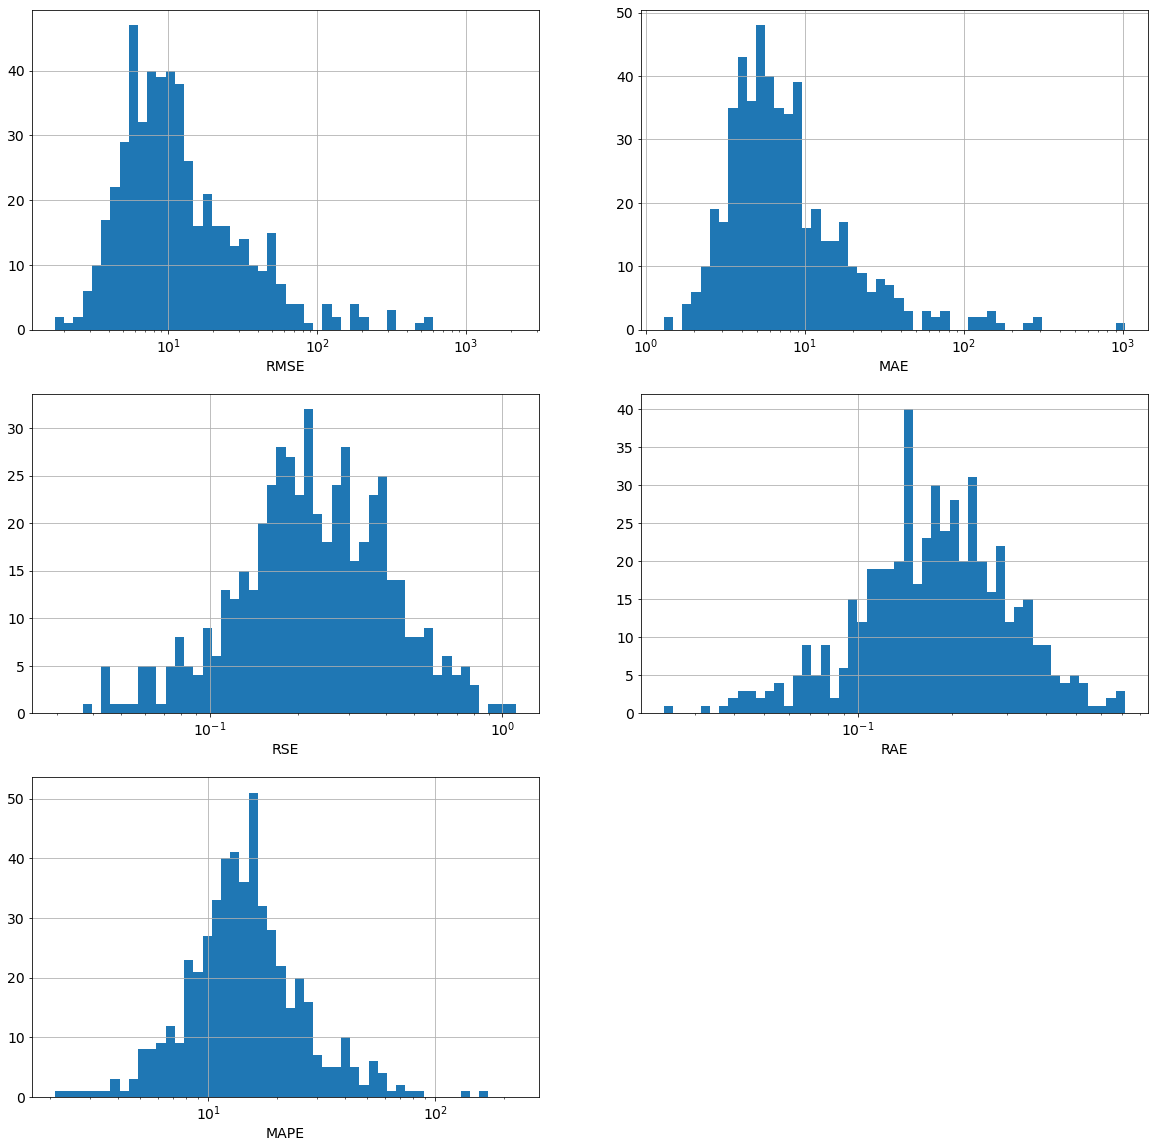

In [25]:
plot_metrics_histogram(report)

34299


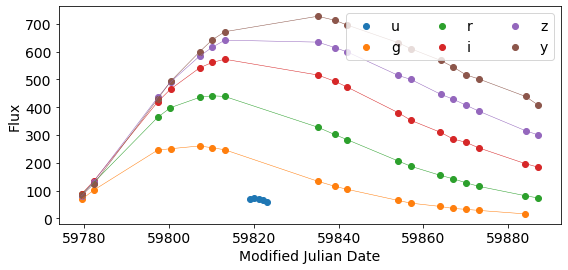

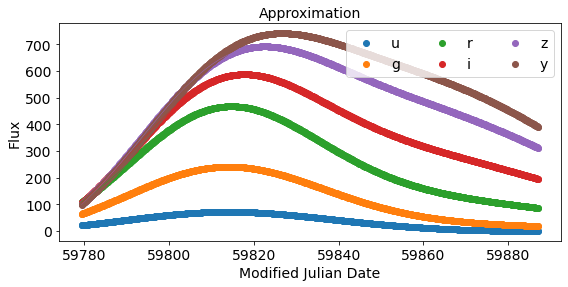

43812


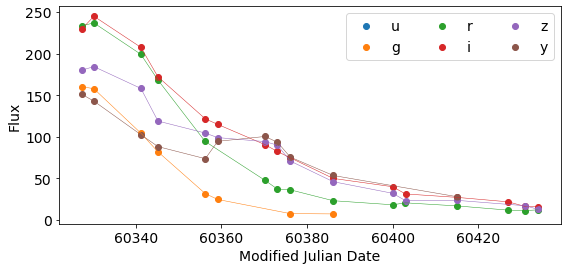

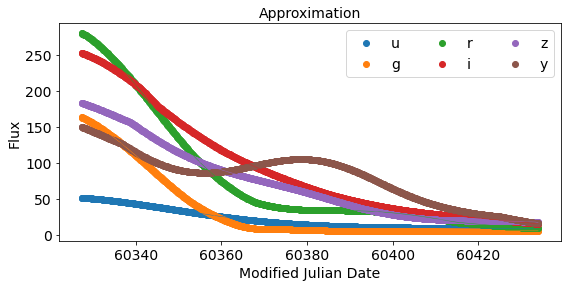

70046


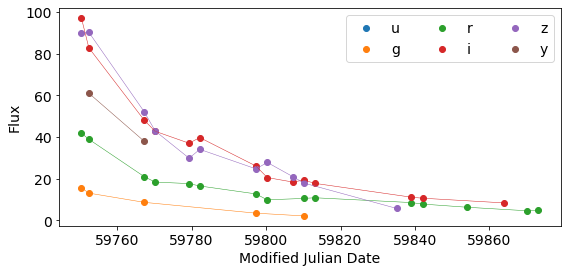

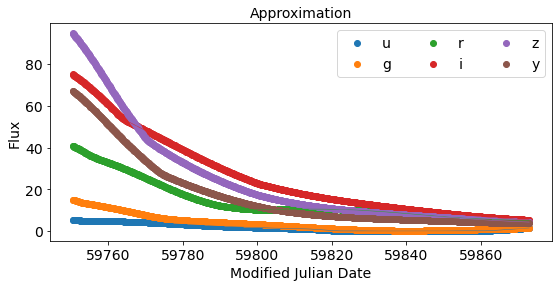

84716


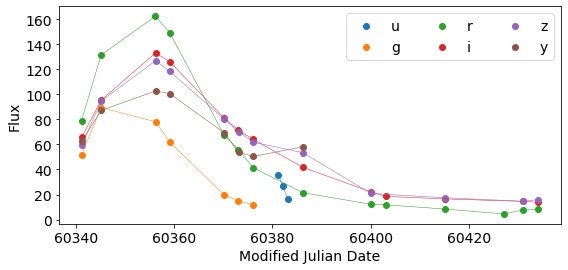

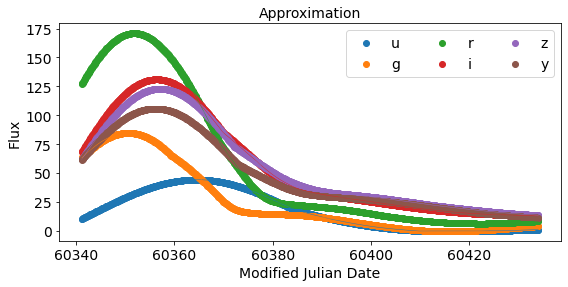

131629


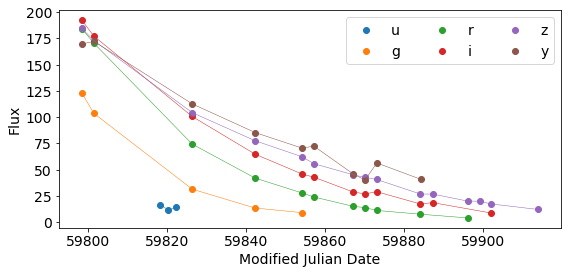

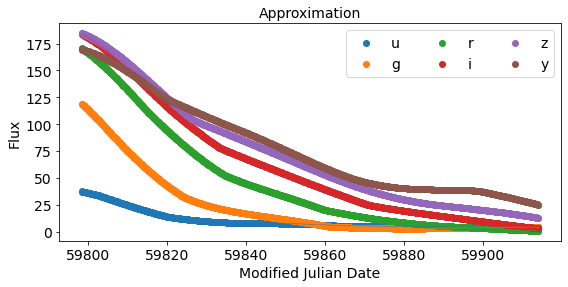

169315


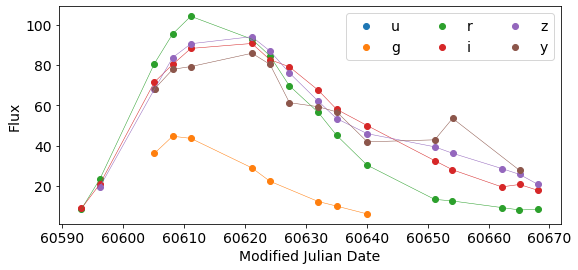

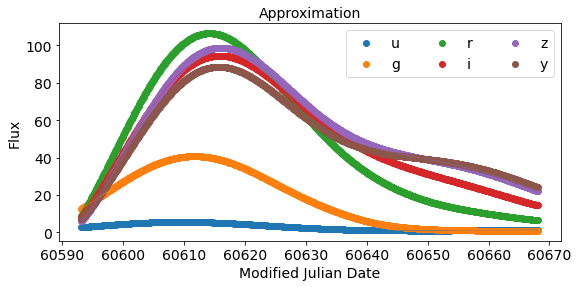

229855


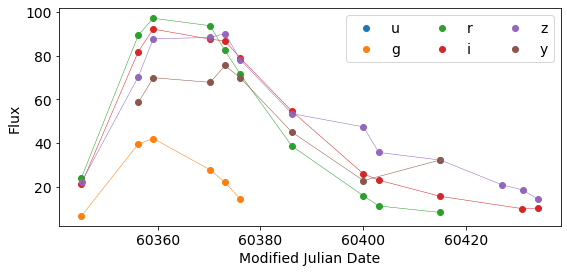

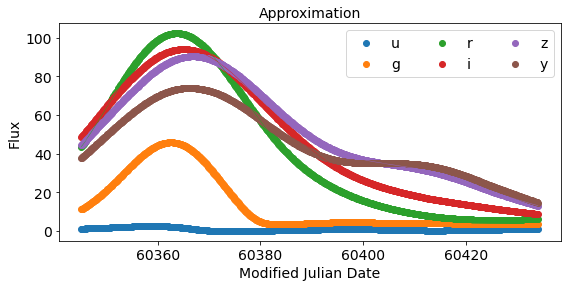

251430


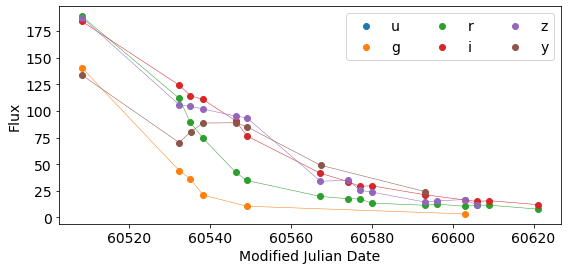

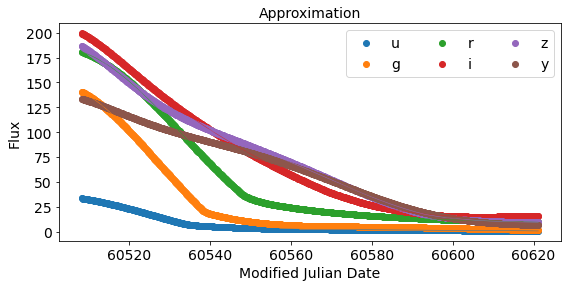

282714


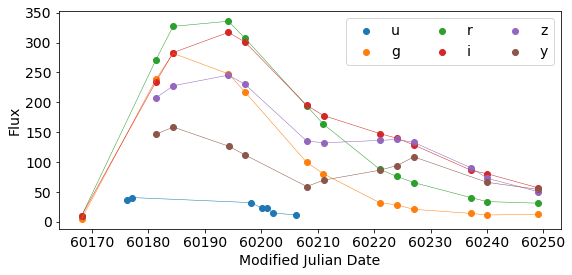

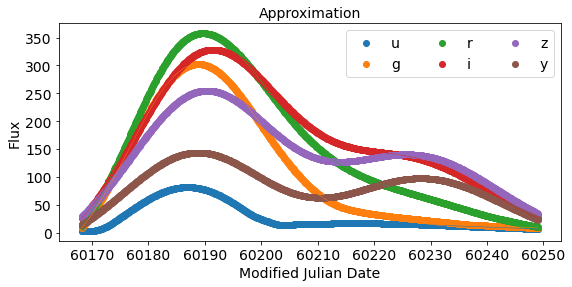

290682


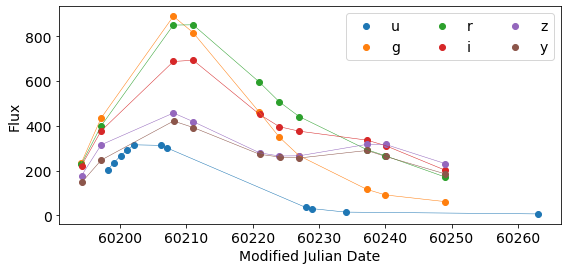

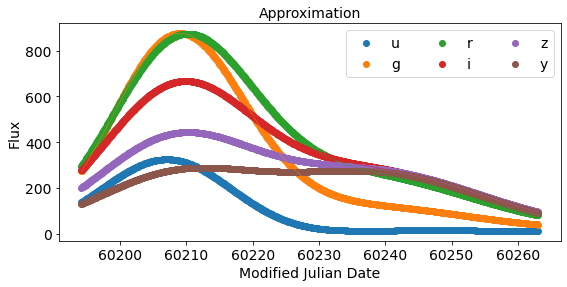

316306


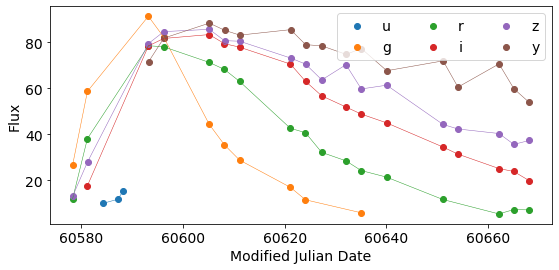

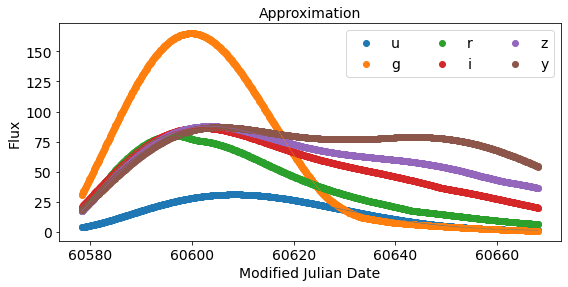

In [26]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()
    
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    model = rbfnet_aug.RBFNetAugmentation(passband2lam, n_hidden=200, lam=0., n_epochs=300, lr=0.01, batch_size=100)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                     anobject['mjd'].max(), n_obs=1000)
    anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)
    plot_light_curves(anobject_aug, "Approximation")
    plt.show()